In [1]:
import os
import json
import multiprocessing as mp
from tqdm import tqdm
import numpy as np

import reneu
from reneu.skeleton import Skeleton
from reneu.xiuli import XVectorCloud, XNBLASTScoreMatrix, XNBLASTScoreTable

DATASET_DIR = os.path.abspath('../01_data')

In [2]:
DATASET_DIR

'/usr/people/jingpeng/workspace/zfish_analysis/01_data'

## build vector clouds

In [3]:
# import h5py
# with h5py.File(os.path.join(DATASET_DIR, 'atlas/nblast/data.h5')) as f:
#     neuron_ids = np.asarray(f['neuronIdList'])

# neuron_ids = list(neuron_ids)


with open(os.path.join(DATASET_DIR, 'neuron_groups.json')) as f:
    d = json.load(f)
    
neuron_ids = []
for k, v in d.items():
    if 'dust' != k and 'anatomically_identified'!=k and 'glia'!=k and 'spiral' not in k:
        neuron_ids.extend( v )
        
print('number of neurons: ', len(neuron_ids))

number of neurons:  3039


In [41]:
# only use the valid neurons with path length > 20 micron

# with open(os.path.join(DATASET_DIR, 'neuron_groups.json')) as f:
#     d = json.load(f)
# neuron_ids = d['analysis']
print(f'get {len(neuron_ids)} neurons to analysis')

is_recenter = False

def read_skeleton(neuron_id, recenter = is_recenter):
    file_name = os.path.join(DATASET_DIR, f'atlas/swc/{neuron_id}.swc')
#     print(file_name)
    assert os.path.exists(file_name)
    
    sk = Skeleton.from_swc(file_name)
    if recenter:
        sk.translate_centroid_to_origin()
    return sk

pool = mp.Pool()
sks = pool.map( read_skeleton, neuron_ids )

# sks = []
# for nid in neuron_ids:
#     print(nid)
#     sk = read_skeleton(nid)
#     sks.append(sk)
    

get 3039 neurons to analysis


# Skeleton Alignment
translate the centroid to origin
or use Iterative Closest Point algorithm to register them.

In [42]:
# %matplotlib notebook


# import matplotlib.pylab as plt
# from mpl_toolkits.mplot3d import Axes3D

# def compare_points(points1, points2, K = 600):
#     fig = plt.figure()
#     ax = fig.gca(projection='3d')
    
#     ax.scatter(points1[:K,0], points1[:K,1], zs=points1[:K, 2], marker='.', s=2)
#     ax.scatter(points2[:K,0], points2[:K,1], zs=points2[:K, 2], marker='.', s=2)

#     plt.show()

# # import sys
# # sys.path.insert(0, os.path.join('/usr/people/jingpeng/workspace/icp'))
# import icp

# nid2points = dict()
# for i, nid in enumerate( neuron_ids ):
#     points = sks[i].points[:, :3]
#     # translate to their centroids
#     nid2points[ nid ] = points


# # compare 78579 and 78585
# neuron_id1 = 78579
# neuron_id2 = 78585

# points1 = nid2points[ neuron_id1 ]
# points2 = nid2points[ neuron_id2 ]
# np.random.shuffle(points1)
# np.random.shuffle(points2)

# compare_points(points1, points2)

In [43]:
# points1 -= np.mean(points1, axis=0)
# points2 -= np.mean(points2, axis=0)

# compare_points(points1, points2)

In [44]:
# N1 = points1.shape[0]
# N2 = points2.shape[0]

# if N1 < N2:
#     N = N1
#     points2 = points2[:N, :]
# else:
#     N = N2
#     points1 = points1[:N, :]
    

# print('number of points: ', N1, ', ', N2)


# T, distances, iterations = icp.icp( points1, points2, tolerance=0.001 )


# C = np.ones((N, 4))
# C[:,0:3] = np.copy(points2)

# # Transform C
# C = np.dot(T, C.T).T

# compare_points(points1, C)

# Path length histogram

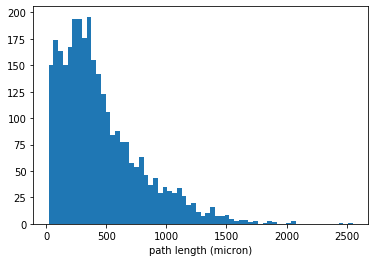

In [45]:
path_lengths = [sk.path_length for sk in sks]

sum(path_lengths)

import matplotlib.pylab as plt
# use LaTeX fonts in the plot
plt.rc('text', usetex=False)
# plt.rc('font', family='Arial')
plt.rcParams['svg.fonttype'] = 'none'
import matplotlib

import numpy as np
path_lengths = np.asarray(path_lengths, dtype=np.float32) / 1000
h = plt.hist(path_lengths, bins=64)
plt.xlabel('path length (micron)')
plt.savefig(os.path.join(DATASET_DIR, 'fig/path_length_hist.svg'), format="svg")

In [46]:
# selected_neuron_ids = []
# for i in range(len(neuron_ids)):
#     neuron_id = neuron_ids[i]
#     sk = sks[ i ]
#     if sk.path_length > 20000:
#         selected_neuron_ids.append(neuron_id)
        
# d['valid_20000'] = selected_neuron_ids

# with open(os.path.join(DATASET_DIR, 'neuron_ids.json'), 'w') as f:
#     json.dump(d, f)

In [47]:
# build vector clouds
def build_vector_cloud(sk):
    return XVectorCloud(sk.points, 10, 10)

# pool = mp.Pool()
# vcs = pool.map( build_vector_cloud, neuron_ids )
vcs = []
for sk in tqdm(sks):
    vc = build_vector_cloud(sk)
    vcs.append(vc)

100%|██████████| 3039/3039 [05:44<00:00,  8.82it/s]


In [48]:
# build score table
st = XNBLASTScoreTable()

In [49]:
import numpy as np
import traceback
import functools

index_chunks = np.array_split(range(len(neuron_ids)), 16)

tasks = []
task_id = 0
for indices1 in index_chunks:
    for indices2 in index_chunks:
        tasks.append( (task_id, 
                       indices1[0], indices1[-1]+1, 
                       indices2[0], indices2[-1]+1) )
        task_id +=1
        
print(f'created {len(tasks)} tasks.')    


def consume_task(task):
    task_id, indices1_start, indices1_stop, indices2_start, indices2_stop = task
    score_matrix_file_name = os.path.join(DATASET_DIR, f'atlas/nblast/sub_score_matrices/{task_id}.npy')
    if os.path.exists(score_matrix_file_name):
        print('task alread exist: ', task)
        return task_id
    
    N1 = indices1_stop - indices1_start
    N2 = indices2_stop - indices2_start
    print(f'processing {task}')
#     print(f'task number: {N1} x {N2} = {N1*N2}')
    scoreMatrix = np.zeros((N1, N2), dtype=np.float32)
#     for i, index1 in tqdm(enumerate(indices1), mininterval=10):
    for i, index1 in enumerate(range(indices1_start, indices1_stop)):
        for j, index2 in enumerate(range(indices2_start, indices2_stop)):
            vc1 = vcs[index1]
            vc2 = vcs[index2]
            scoreMatrix[i,j] = vc1.query_by(vc2, st)
            
    print(f'save score matrix for task id: {task_id}')
    np.save(score_matrix_file_name, scoreMatrix)
    return task_id     
    
def consume_task_wrapped(task):
    try:
        consume_task(task)
    except:
        print(f'task {task[0]} has error: {trackback.format_exc()}')
        
def consume_tasks(tasks):
    for task in tasks:
        consume_task( task )
        
# results = pool.map( functools.partial(consume_task), tasks[230:] )
# results = pool.map(consume_task_wrapped, tasks)  
# results = pool.map(consume_task, tasks[0:33])
# consume_task(tasks[0])

# results = []
# for task in tqdm(tasks[255:]):
#     results.append( consume_task(task) )
        

created 256 tasks.


In [50]:
import math

ps = []
process_num = 32
task_num = math.ceil(len(tasks)/process_num)
for i in range(32):
    p = mp.Process(target=consume_tasks, args=(tasks[i*task_num:i*task_num+task_num],))
    ps.append(p)
    p.start()

for p in ps:
    p.join()
    p.close()

processing (0, 0, 190, 0, 190)
processing (8, 0, 190, 1520, 1710)
processing (16, 190, 380, 0, 190)
processing (24, 190, 380, 1520, 1710)
processing (32, 380, 570, 0, 190)
processing (40, 380, 570, 1520, 1710)
processing (48, 570, 760, 0, 190)
processing (56, 570, 760, 1520, 1710)
processing (64, 760, 950, 0, 190)
processing (72, 760, 950, 1520, 1710)
processing (80, 950, 1140, 0, 190)
processing (88, 950, 1140, 1520, 1710)
processing (96, 1140, 1330, 0, 190)
processing (104, 1140, 1330, 1520, 1710)
processing (112, 1330, 1520, 0, 190)
processing (120, 1330, 1520, 1520, 1710)
processing (128, 1520, 1710, 0, 190)
processing (136, 1520, 1710, 1520, 1710)
processing (144, 1710, 1900, 0, 190)
processing (152, 1710, 1900, 1520, 1710)
processing (160, 1900, 2090, 0, 190)
processing (168, 1900, 2090, 1520, 1710)
processing (176, 2090, 2280, 0, 190)
processing (184, 2090, 2280, 1520, 1710)
processing (192, 2280, 2470, 0, 190)
processing (200, 2280, 2470, 1520, 1710)
processing (208, 2470, 2660

save score matrix for task id: 86
processing (87, 950, 1140, 1330, 1520)
save score matrix for task id: 122
processing (123, 1330, 1520, 2090, 2280)
save score matrix for task id: 101
processing (102, 1140, 1330, 1140, 1330)
save score matrix for task id: 10
processing (11, 0, 190, 2090, 2280)
save score matrix for task id: 195
processing (196, 2280, 2470, 760, 950)
save score matrix for task id: 102
processing (103, 1140, 1330, 1330, 1520)
save score matrix for task id: 51
processing (52, 570, 760, 760, 950)
save score matrix for task id: 154
processing (155, 1710, 1900, 2090, 2280)
save score matrix for task id: 67
processing (68, 760, 950, 760, 950)
save score matrix for task id: 18
processing (19, 190, 380, 570, 760)
save score matrix for task id: 170
processing (171, 1900, 2090, 2090, 2280)
save score matrix for task id: 116
processing (117, 1330, 1520, 950, 1140)
save score matrix for task id: 25
processing (26, 190, 380, 1900, 2090)
save score matrix for task id: 132
processing 

save score matrix for task id: 23
save score matrix for task id: 14
processing (15, 0, 190, 2850, 3039)
save score matrix for task id: 237
processing (238, 2660, 2850, 2660, 2850)
save score matrix for task id: 45
processing (46, 380, 570, 2660, 2850)
save score matrix for task id: 253
processing (254, 2850, 3039, 2660, 2850)
save score matrix for task id: 221
processing (222, 2470, 2660, 2660, 2850)
save score matrix for task id: 189
processing (190, 2090, 2280, 2660, 2850)
save score matrix for task id: 60
processing (61, 570, 760, 2470, 2660)
save score matrix for task id: 76
processing (77, 760, 950, 2470, 2660)
save score matrix for task id: 143
save score matrix for task id: 127
save score matrix for task id: 158
processing (159, 1710, 1900, 2850, 3039)
save score matrix for task id: 205
processing (206, 2280, 2470, 2660, 2850)
save score matrix for task id: 27
processing (28, 190, 380, 2280, 2470)
save score matrix for task id: 174
processing (175, 1900, 2090, 2850, 3039)
save s

In [51]:
# import ray
# ray.init()

# @ray.remote
# class Mapper:
#     def __init__(self):
#         pass
    
#     def compute_score_matrix(self, tasks):
#         for task in tasks:
#             consume_task(task)
        
# mappers = [Mapper.remote() for _ in range(mp.cpu_count())]

# futures = []
# for i, mapper in enumerate(mappers):
#     result = mapper.compute_score_matrix.remote( tasks[2*i: 2*i+2] )
#     futures.append(result)
    
    
# ray.get(futures)
        

100%|██████████| 256/256 [00:10<00:00, 23.62it/s]


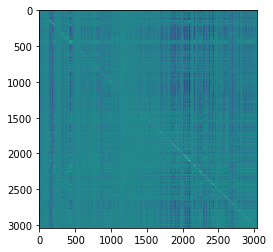

In [52]:
N = len(neuron_ids)
scoreMatrix = np.zeros((N, N), dtype=np.float32)
for task_id, indices1_start, indices1_stop, indices2_start, indices2_stop in tqdm(tasks):
    subScoreMatrix = np.load(os.path.join(DATASET_DIR, f'atlas/nblast/sub_score_matrices/{task_id}.npy'))
    scoreMatrix[indices1_start:indices1_stop, indices2_start:indices2_stop] = subScoreMatrix
    
np.save(os.path.join(DATASET_DIR, 'atlas/nblast/score_matrix.npy'), scoreMatrix)
plt.imshow(scoreMatrix)

In [53]:
N = scoreMatrix.shape[0]
self_score = scoreMatrix[range(N), range(N)]

np.testing.assert_array_equal( self_score, np.max(scoreMatrix, 0) )

normalized_score_matrix = scoreMatrix / self_score
assert np.max(normalized_score_matrix) == 1

mean_score_matrix = (normalized_score_matrix + normalized_score_matrix.transpose()) / 2

# remove a bad neurons

In [54]:
# from copy import copy
# # bad_nid = 77240

# def find_index(neuron_ids):
#     for i, nid in enumerate(neuron_ids):
#         if nid==bad_nid:
#             return i
        
# idx = find_index(neuron_ids)
# neuron_ids2 = copy(neuron_ids)
# neuron_ids2.pop(idx)

# assert len(neuron_ids) == len(neuron_ids2) + 1

# neuron_ids.remove(bad_nid)

# print('find matching index: ', idx)

# N = mean_score_matrix.shape[0]
# indices = list(range(N))
# indices.remove(idx)
# assert len(indices) == N - 1

# # delete the corresponding row and column
# mean_score_matrix2 = np.delete(mean_score_matrix, idx, axis=0)
# mean_score_matrix2 = np.delete(mean_score_matrix2, idx, axis=1)
# mean_score_matrix = mean_score_matrix2
# mean_score_matrix2.shape

# # neuron_ids[idx]
# scoreMatrix2 = np.delete(scoreMatrix, idx, axis=0)
# scoreMatrix2 = np.delete(scoreMatrix2, idx, axis=1)

# scoreMatrix = scoreMatrix2

# scoreMatrix.shape

# import h5py

# assert len(neuron_ids) == scoreMatrix.shape[0]

    

In [55]:
# with h5py.File(os.path.join(DATASET_DIR, 'atlas/nblast/data.h5'), 'a') as f:
import h5py

if is_recenter:
    with h5py.File(os.path.join(DATASET_DIR, 'atlas/nblast/data.h5'), 'a') as f:
        f['neuronIdList'] = np.asarray(neuron_ids, dtype=np.int64)
        f['recentered/scoreMatrix'] = scoreMatrix
        f['recentered/meanScoreMatrix'] = mean_score_matrix
else:
    with h5py.File(os.path.join(DATASET_DIR, 'atlas/nblast/data.h5'), 'a') as f:
        f['neuronIdList'] = np.asarray(neuron_ids, dtype=np.int64)
        f['meanScoreMatrix'] = mean_score_matrix
        f['scoreMatrix'] = scoreMatrix

In [56]:
# with h5py.File(os.path.join(DATASET_DIR, 'atlas/nblast/data_original.h5'), 'a') as f:
#     originalScoreMatrix = np.asarray(f['scoreMatrix'])
#     originalMeanScoreMatrix = np.asarray(f['meanScoreMatrix'])
    
# with h5py.File(os.path.join(DATASET_DIR, 'atlas/nblast/data.h5'), 'a') as f:
#     f['meanScoreMatrix'] = originalMeanScoreMatrix
#     f['scoreMatrix'] = originalScoreMatrix
#     f['neuronIdList'] = np.asarray(neuron_ids, dtype=np.int64)

# Add group name for nblast clustering

In [57]:
# with open(os.path.join(DATASET_DIR, 'atlas/nblast/manual_adjusted_neuron_groups.json')) as f:
#     ngs = json.load(f)
    
# neuron_groups = dict()
# for i, neuron_ids in enumerate(ngs):
#     neuron_groups[ str(i) ] = neuron_ids
    
# json.dumps( neuron_groups )